# Optimal network reinforcement solution for distributed generation rise.

Description of the project

In [41]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
from pandapower.plotting import cmap_continuous, cmap_discrete, create_bus_collection, create_line_collection, draw_collections
import pandas
import numpy as np
import geopandas

 ### Initial network: Illinois200 case study with a generator to connect

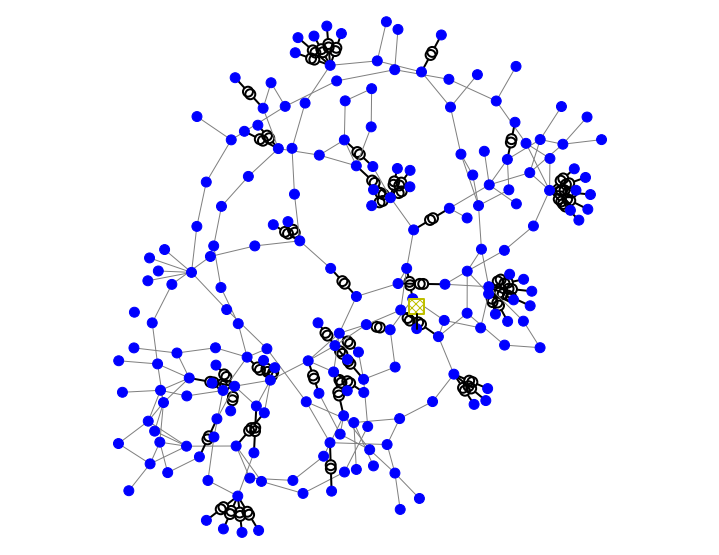

In [98]:
network = pn.case_illinois200()
pp.runpp(network)
#pandapower.to_excel(network, "AC_datas.xlsx")

#Calculate the length of the lines
for i,length in enumerate(network.line['length_km']):
    x1,y1 = float(network.bus_geodata['x'][network.line['from_bus'][i]]), float(network.bus_geodata['y'][network.line['from_bus'][i]])
    x2,y2 = float(network.bus_geodata['x'][network.line['to_bus'][i]]), float(network.bus_geodata['y'][network.line['to_bus'][i]])
    network.line['length_km'][i] = np.sqrt((x1-x2)**2+(y1-y2)**2)

#Creating the generator
x_gen, y_gen = -3.534,1.813 #Determine on QGis
pp.create_bus(network,geodata=(x_gen,y_gen),vn_kv=115) #Change the value of vn_kv?
#Create generator at the created node (200)
pp.create_gen(network, 200,p_mw=0,max_p_mw=100,min_p_mw=5) #Change the p_mw, max and min value?


pandapower.plotting.simple_plot(network);

### Example of connexion to the grid

0.6762621756185523


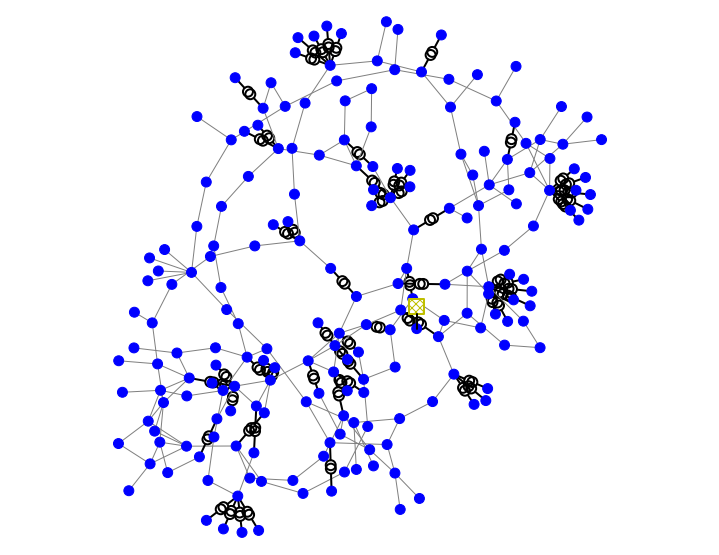

In [99]:
#Exemple of connexion to node 118
#Determine length
x_nod = float(network['bus_geodata']['x'][network['bus_geodata'].index==118])
y_nod = float(network['bus_geodata']['y'][network['bus_geodata'].index==118])
len_con = np.sqrt((x_gen-x_nod)**2+(y_gen-y_nod)**2);print(len_con)
#Create line
pp.create_line(network,200,118,length_km=len_con,std_type="NA2XS2Y 1x185 RM/25 12/20 kV")
#Plot
pandapower.plotting.simple_plot(network);

In [100]:
#My function of the Exercice in class for technical constraint
def isThereViolation(net,vnmin=0.9,vnmax=1.1):
    ttmax = net.trafo['sn_mva'] #max
    tlmax = net.line['max_i_ka']
    tt = np.sqrt(net.res_trafo['p_hv_mw']+net.res_trafo['q_hv_mvar']**2) #thermal transformators
    tl = net.res_line['i_ka'] #thermal lines
    vn = net.res_bus['vm_pu'] # voltage nodes
    alert = sum(vn>vnmax) + sum(vn<vnmin)+ sum(tt>ttmax) + sum(tl>tlmax)
    return alert>0